# Independent Component Analysis (ICA) 

NGUYEN Binh Minh

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Introduction

### Context
Imaging that when you are talking with another person in a party, where your ear bombarded by the sound coming from the conversations of other people and the music. Yet, none of this can prevent you from listening to that person since human possesses the ability to differentiate between sounds.

However, if this were taking place in a movie scene, the microphone used to record was lack of capacity to differentiate between all the sounds going on in the room. This is where _Independent Component Analysis (ICA)_ plays its role. With ICA, we can decompose the conversation between you and another person from the amalgamation of multiple signals. 

In ICA model, it assumes that the observed signal *x* is a linear combination of independent components: 

<h3 align="center">$x=As$</h3>

where *s* are the source signals (components) and _A_ is the mixing matrix.

### Retrieving the components

To find the independent source _s_, we need to inverse matrix A. The mathematical expression is:
<h3 align="center">$W=A^{-1}$</h3>

<h3 align="center">$s=xW$</h3>

Therefore, the parameters that ICA algorithm needs to estimate is *W*. 



## 2. Algorithm

To get an optimal estimation of the independent components, it is advisable to do some pre-processing of the data. In the following the two most important pre-processing techniques are explained in more detail.

The first pre-processing step we will discuss here is <b> centering </b>. This is a simple subtraction of the mean from our input X. As a result, the centered mixed signals will have zero mean which implies that also our source signals s are of zero mean. The mean can later be added back.


In [2]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

The second step is called <b> Whitening </b>. It means that we transform the signal in a such way so that the potential correlations between its other components are removed and the variance of each component is equal to 1 (that indicates the independence between components). On the other hand, it simplifies that the covariance matrix of whitened signal is equal to identity matrix.

Whitening a signal involves the eigen-value decomposition of its covariance matrix. The corresponding mathematical equation is:

$$ \begin{equation}
\tilde{{\bf x}}={\bf E}{\bf D}^{-1/2}{\bf E}^T {\bf x}
\end{equation} $$

where D is a diagonal matrix of eigenvalues, E is an orthogonal matrix of eigenvectors and $\tilde{{\bf x}}$ is the whitened signal.

In [3]:
def whiten(X):
    # Calculate the covariance matrix
    coVarM = np.cov(X) 
    
    # Find the diagonal matrix of eigenvalues and orthogonal matrix of eigenvectors (E and D). 
    d, E = np.linalg.eigh(coVarM)
    #D = np.diag(d)
    
    # Calculate inverse square root diagonal matrix of eigenvalues: (D_inv = D^-1/2 in the formula)
    D_inv = np.diag(1.0 / np.sqrt(d)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(E, np.dot(D_inv, E.T))
    
    # Calculate whitened signal.
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM 

After these pre-processing steps, we use an algorithm called <b> Fast ICA </b> to update and find the weights in *W* matrix in order to retrieve the independent components.

In this algorithm, we need to use the equations $g$ and $g'$ which are derivatives of $f(u)$ as defined below.
<h3 align="center">$f(u)=\log \cosh(u)$</h3> 

<h3 align="center">$g(u)=\tanh(u)$</h3> 

<h3 align="center">$g'(u)=1-\tanh^{2}(u)$</h3> 

The iterative algorithm is: 
<h3>$for\ 1\ to\ number\ of\ components\ C:$</h3>

<h3>$\ \ \ \ \ \ \ \ w_{p} = random\ initialisation$</h3>

<h3>$\ \ \ \ \ \ \ \ while\ |w_{p}^T  \ w_{p-1}-1|\geq threshold:$</h3>

<h3>$\ \ \ \ \ \ \ \ \ \ \ \ \ w_{p} = \frac{1}{M}(Xg(w_{p}^T X) - g'(w_{p}^T X)w_{p})$</h3>

<h3>$\ \ \ \ \ \ \ \ \ \ \ \ \ w_{p} = w_{p}-\sum_{j=1}^{p-1}(w_{p}^{T}w_{j})w_{j}$</h3>

<h3>$\ \ \ \ \ \ \ \ \ \ \ \ \ w_{p} = w_{p}/||w_{p}||$</h3>

<h3>$\ \ \ \ \ \ \ \ W = [w_{1},...,w_p,...,w_{C}]$</h3> 

With the inputs and outputs information:

Input: $C$ Number of desired components. 

Input: $X \in R^{NxM}$ whitened matrix, in which each column represents an N-dimensional sample ($C \leq N$). 

Output: $W \in R^{CxM}$ un-mixing matrix where each column contains the weight values which are used to project $X$ onto independent component. 
        

This iterative algorithm will find the direction for the weight vector $w$ that maximizes a measure of non-Gaussianity of the projection $w^T X$. To mesure non-Gaussianity, we need to use the function $f$ and its first and second derivative $g$ and $g'$ indicated above. 

In this algorithm, firstly we need to initialize a weight vector. Then we repeat the process until we have reached all the components. In the while loop, we pass the result of dot product between *W* and *X* to function $g$ and $g'$ and we do a subtraction and calculate the mean. Then we can divide the weight by its norm and continue the iteration until the stop condition is sastisfied. However, we may face a problem that in the iteration for the second component we might find the same component as in the first iteration. To solve this, we need to decorrelate the weight and dividing to its norm as in the two final steps in the while loop.

In [4]:
def fastIca(X, C, epsilon=1e-8, iterations=5000):

    nb_components = C
    
    # Initialize random weights
    W = np.random.rand(nb_components, nb_components)

    for c in range(nb_components):
            w = W[c, :].copy().reshape(nb_components, 1)
            #w = w / np.sqrt((w ** 2).sum())

            i = 0 # Initial number of iterations.
            lim = 100
            while ((lim > epsilon) & (i < iterations)):

                # Dot product of weight and X
                ws = np.dot(w.T, X)

                # Pass w*s into function g
                wg = np.tanh(ws).T

                # Pass w*s into g's derivative 
                wg_ = (1 - np.square(np.tanh(ws)))

                # Update weights
                wNew = (X * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update number of iteration
                i += 1

            W[c, :] = w.T
    return W

## 3. Implement Fast ICA algorithm

### Create toy signals

We will start by creating some independent signals that will be mixed by matrix A. 

In [5]:
np.random.seed(0)
n_samples = 2000
ns = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * ns)  # sinusoidal
s2 = np.sign(np.sin(3 * ns))  # square signal
s3 = signal.sawtooth(2 * np.pi * ns)  # saw tooth signal

# Source matrix
S = np.c_[s1, s2, s3]

# Mixing matrix
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])

# Mixed signal matrix
X = np.dot(S, A.T)
X = X.T

Text(0.5, 1.0, 'real sources')

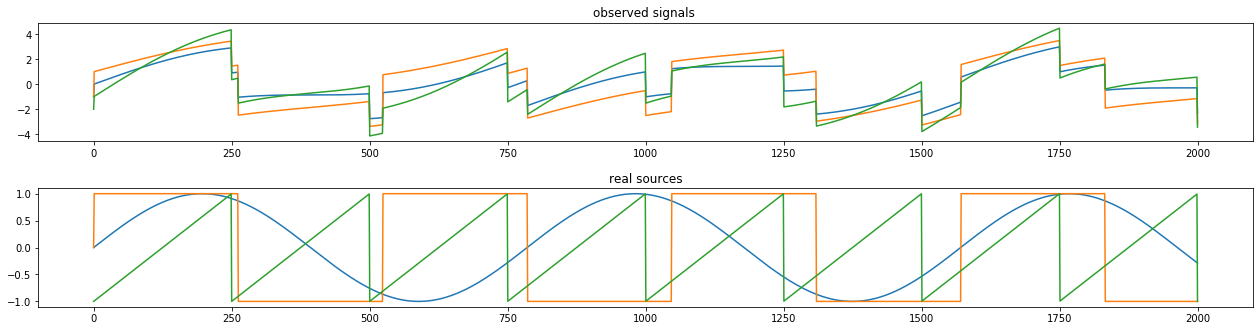

In [6]:
# Plot sources & signals
fig = plt.figure(figsize=[18, 5])
plt.subplot(2, 1, 1)
for x in X:
    plt.plot(x)
plt.title("observed signals ")
fig. tight_layout(pad=3.0)
plt.subplot(2, 1, 2)
for s in [s1,s2,s3]:
    plt.plot(s)
plt.title("real sources")

The source signals contists of 3 separated signals. Now we use Fast ICA algorithm to separated these 3 signals from the mixtures (or observed signals).



## Implement ICA 

Before running Fast ICA, we need to do some pre-processing steps: centering and whitening.

In [7]:
# Take centered signals from mixed signals
Xc, meanX = center(X) 

# Whiten centered mixed signals
Xw, whiteM = whiten(Xc)


Check the whitened signal to make sure its covariance is almost equal to identity matrix

In [8]:
print (np.cov(Xw))

[[ 1.00000000e+00 -6.60779863e-15 -8.38148960e-15]
 [-6.60779863e-15  1.00000000e+00  2.92534603e-15]
 [-8.38148960e-15  2.92534603e-15  1.00000000e+00]]


We observe that the covariance matrix is almost identity. 

Now we apply the Fast ICA algorithm

Text(0.5, 1.0, 'real sources')

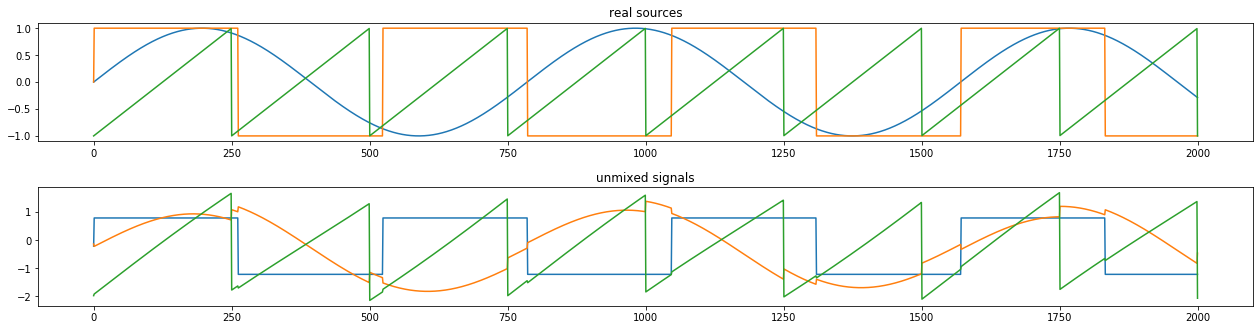

In [9]:
C = Xw.shape[0]
W = fastIca(Xw,C)

#Un-mix signals: s = xW
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX)

# Plot
fig = plt.figure(figsize=[18, 5])
plt.subplot(2, 1, 2)
for x in unMixed:
    plt.plot(x)
plt.title("unmixed signals")

fig. tight_layout(pad=3.0)
plt.subplot(2, 1, 1)
for s in [s1,s2,s3]:
    plt.plot(s)
plt.title("real sources")

The 3 independent component are well reconstructed with a little differences in amplitudes. This result is quite acceptable.

## ICA with Sklearn

The sklearn library has provided the fastICA algorithm function. We will test with the same example like above.

Text(0.5, 1.0, 'mixed signals')

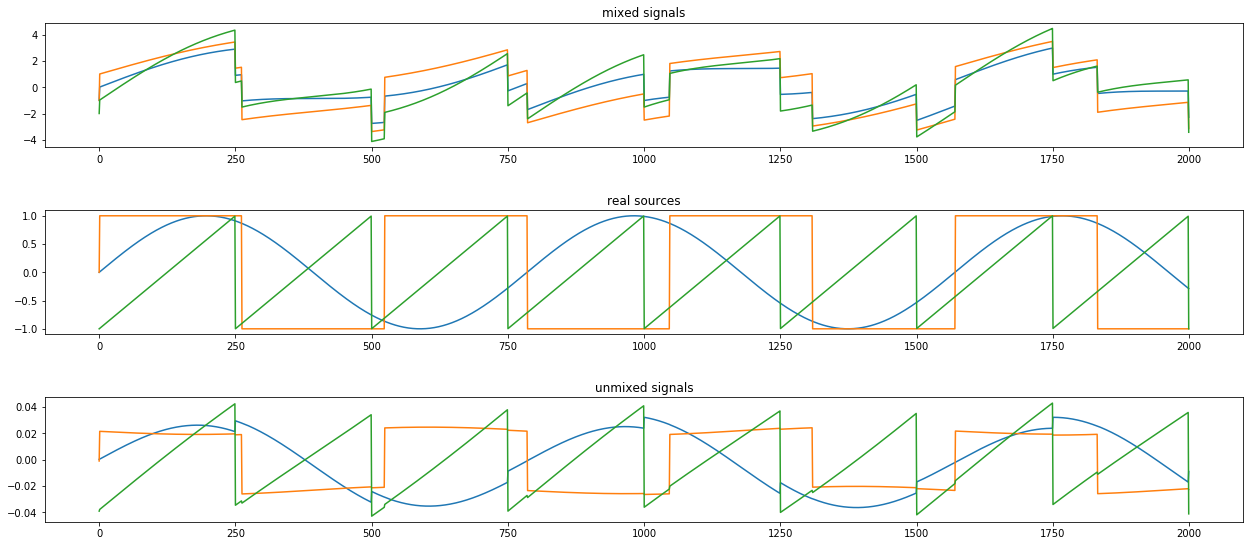

In [10]:
from sklearn.decomposition import FastICA
np.random.seed(8)
ica = FastICA(n_components=3,algorithm='deflation')
S_ = ica.fit_transform(X.T)
S_ = S_.T 

#plot
fig = plt.figure(figsize=[18, 8])
plt.subplot(3, 1, 3)
for x in S_:
    plt.plot(x)
plt.title("unmixed signals")

fig. tight_layout(pad=3.0)
plt.subplot(3, 1, 2)
for s in [s1,s2,s3]:
    plt.plot(s)
plt.title("real sources")

fig. tight_layout(pad=3.0)
plt.subplot(3, 1, 1)
for x in X:
    plt.plot(x)
plt.title("mixed signals")

We observe that with the function FastICA of sklearn library provides the same shapes for each independent signals after decomposing. However the attitude of the signals could not be reconstruced exactly as the original ones. Nevertheless, most of the characteristics of 3 independent signals have been maintained. Therefore this result is acceptable.

## 4. Pyrat Datasets

In this section, we will decompose the pyrat data set on python wins and draws games to analyse their characteristics 

### a) Cheese distribution

In this part, we will observe the cheese distribution in 3 kinds of games: python wins, looses and draw

In [11]:
# Load pyrat dataset
filename = "x.npz"

loaded_npz = np.load(filename)
x_py = loaded_npz["data"]

filename = "y.npz"
loaded_npz = np.load(filename)
y_py = loaded_npz["data"]
i = np.argwhere (y_py == 0) #identify the positions of draw games.
j = i[0:307] # selecte the first 307 draw games
x_py = np.delete(x_py,j,0)
y_py = np.delete(y_py,j,0)


In [12]:
# Select the games in which python looses and calculate their mean
x_py_looses = x_py[np.where(y_py == -1)]
y_py_looses = y_py[np.where(y_py == -1)]
x_py_looses_mean = np.mean(x_py_looses.reshape(np.shape(x_py_looses)[0],5,5),axis = 0)
# Select the games in which python wins and calculate their mean
x_py_wins = x_py[np.where(y_py == 1)]
y_py_wins = y_py[np.where(y_py == 1)]
x_py_wins_mean = np.mean(x_py_wins.reshape(np.shape(x_py_wins)[0],5,5),axis = 0)
# Select the games in which python draws and calculate their mean
x_py_draws = x_py[np.where(y_py == 0)]
y_py_draws = y_py[np.where(y_py == 0)]
x_py_draws_mean = np.mean(x_py_draws.reshape(np.shape(x_py_draws)[0],5,5),axis = 0)

x_py_mean = np.concatenate((x_py_looses_mean.reshape(1,25),x_py_wins_mean.reshape(1,25),x_py_draws_mean.reshape(1,25)))
titles = (['Python looses'],['Python wins'],['Python draws'])

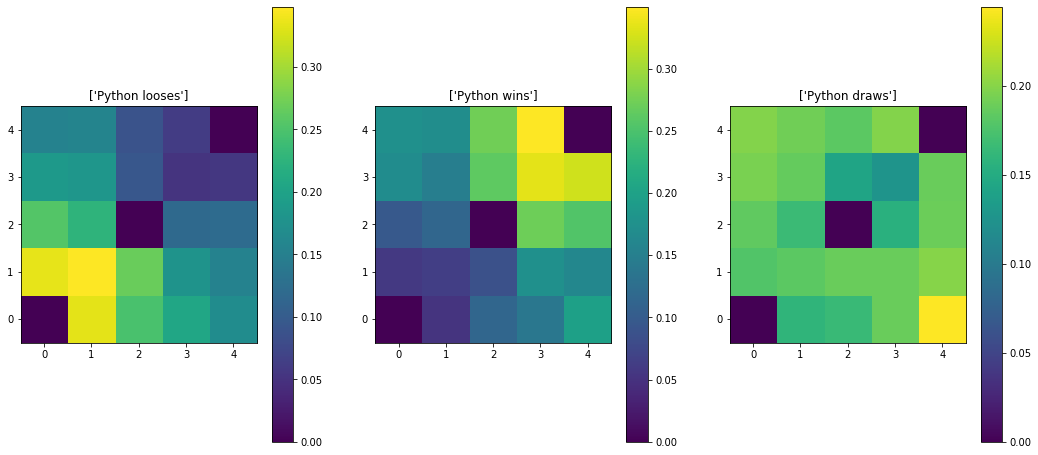

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[18, 8])
for i in range(3):
    
    plt.subplot(1,3,i+1)
    plt.imshow(x_py_mean[i].reshape((5,5)))
    plt.title(titles[i])
    plt.gca().invert_yaxis()
    plt.colorbar()
    #plt.show()

We can see that python will win if more cheese is distributed near its position than pyrat's position and vice versa. The game is draw if the cheese distribution is equal to python and pyrat.

### b) Implement ICA on Pyrat Datasets

I will analyse the characteristics of pyrat datasets for 3 kinds of games. In this part, I use 2 approaches: image approach and signal approach.

In [36]:
# we separate datasets into 3 kinds of games
# Python looses
x_py_looses = x_py[np.where(y_py == -1)]
y_py_looses = y_py[np.where(y_py == -1)]
# Python wins
x_py_wins = x_py[np.where(y_py == 1)]
y_py_wins = y_py[np.where(y_py == 1)]
# Draw game
x_py_draw = x_py[np.where(y_py == 0)]
y_py_draw = y_py[np.where(y_py == 0)]

#### Image approach

In this approach, I find the components of 3 kinds of games under image-type components so that we can visualize them.

In [37]:
# Implement ICA algorithm to decompose for 3 kinds of game 
# To facilitate the visualisation process, I only use 5 components
transformer = FastICA(n_components=2,algorithm='deflation',whiten=True,
             random_state=0)
# Before fitting the model to the dataset, I centered them.
x_py_loosesc, x_py_loosesmeanX = center(x_py_looses)
x_py_winsc, x_py_winsmeanX = center(x_py_wins)
x_py_drawc, x_py_drawmeanX = center(x_py_draw)
# Fit the model
X_transformed1 = transformer.fit_transform(x_py_loosesc)
X_w1 = transformer.components_
X_transformed2 = transformer.fit_transform(x_py_drawc)
X_w2 = transformer.components_
X_transformed3 = transformer.fit_transform(x_py_winsc)
X_w3 = transformer.components_

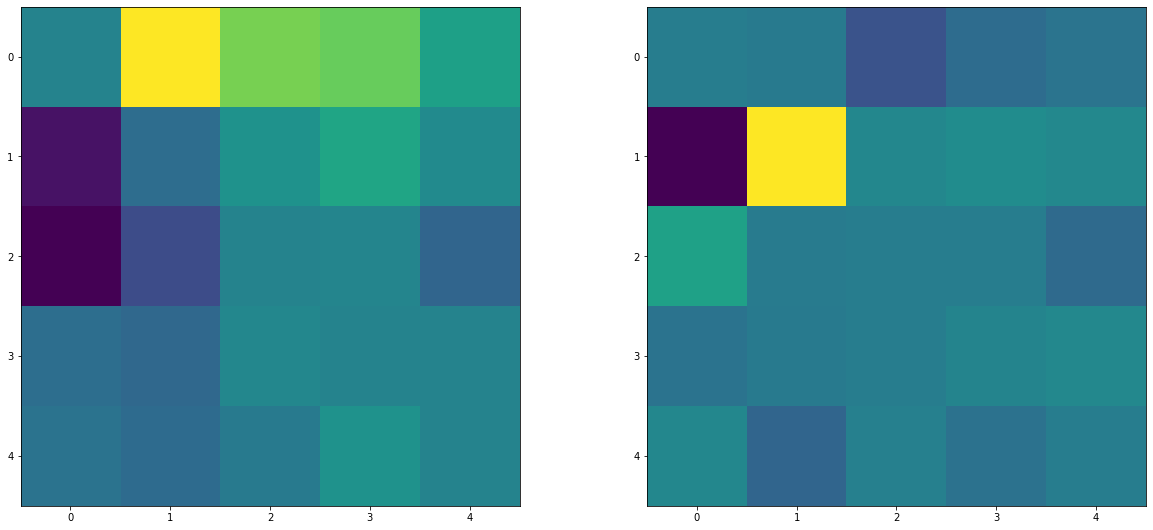

In [38]:
fig = plt.figure(figsize=[18, 8])
i,j = 1,1
for x in X_w1:
    fig. tight_layout(pad=3.0)
    plt.subplot(1,X_w1.shape[0], i)
    plt.imshow(x.reshape(5,5))
    #plt.title("Component " + str(j) + ", Python looses")
    i = i+1
    j = j+1

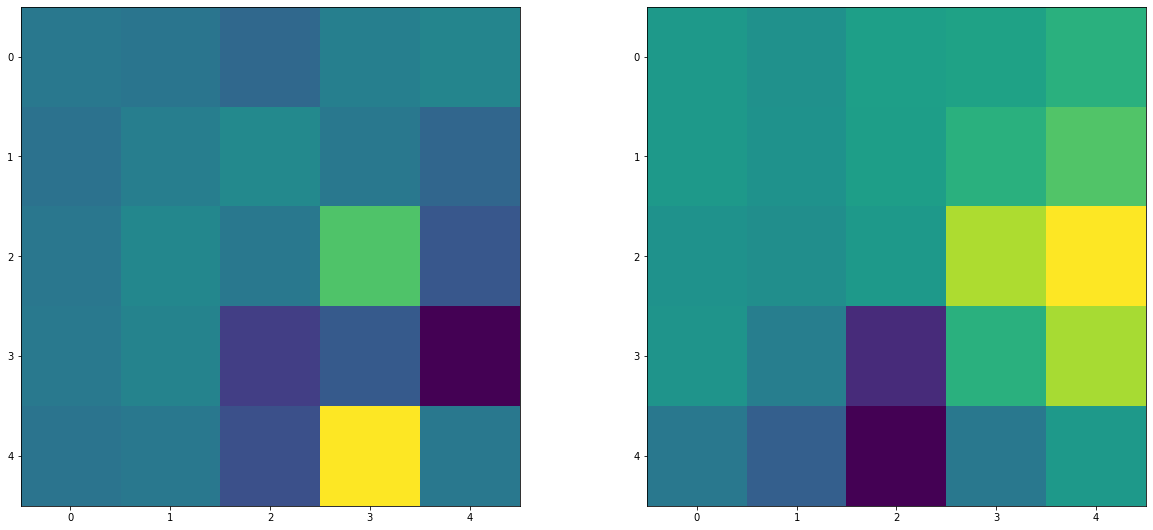

In [39]:
fig = plt.figure(figsize=[18, 8])
i,j = 1,1
for x in X_w3:
    fig. tight_layout(pad=3.0)
    plt.subplot(1,X_w1.shape[0], i)
    plt.imshow(x.reshape(5,5))
    #plt.title("Component " + str(j) + ", Python wins")
    i = i+1
    j = j+1

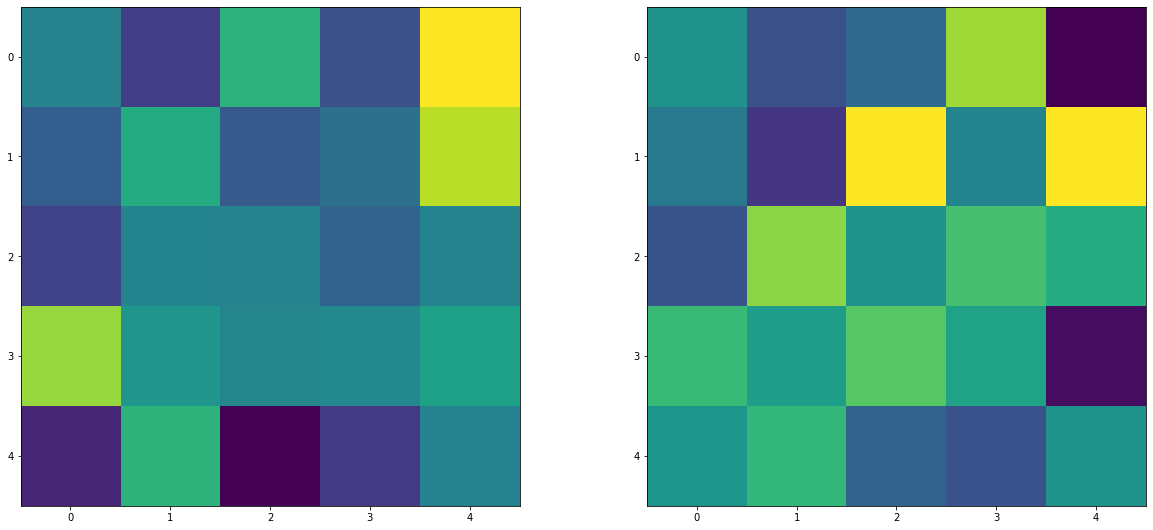

In [40]:
fig = plt.figure(figsize=[18, 8])
i,j = 1,1
for x in X_w2:
    fig. tight_layout(pad=3.0)
    plt.subplot(1,X_w2.shape[0], i)
    plt.imshow(x.reshape(5,5))
    #plt.title("Component " + str(j) + ", Python draws")
    i = i+1
    j = j+1

With this kind of approach, it is difficult to indicate the characteristics of each kind of game because the images are ambiguous and they will change depending on the number of components. Thus we can not conclude much about the characteristics through this approach. 

#### Signal approach

In this approach, I extract the components in signal-type like part 3.

Firstly, let's discover the dataset in which python looses and wins because two of them possess almost the same amount of samples in the dataset 

In [31]:
# Implement ICA algorithm to decompose for 3 kinds of game 
# To facilitate the visualisation process, I only use 5 components
transformer = FastICA(n_components=1,algorithm='deflation',whiten=True,
             random_state=0)
# Before fitting the model to the dataset, I centered them.
x_py_loosesc, x_py_loosesmeanX = center(x_py_looses)
x_py_winsc, x_py_winsmeanX = center(x_py_wins)
x_py_drawc, x_py_drawmeanX = center(x_py_draw)
# Fit the model
X_transformed1 = transformer.fit_transform(x_py_loosesc)
X_transformed2 = transformer.fit_transform(x_py_drawc)
X_transformed3 = transformer.fit_transform(x_py_winsc)


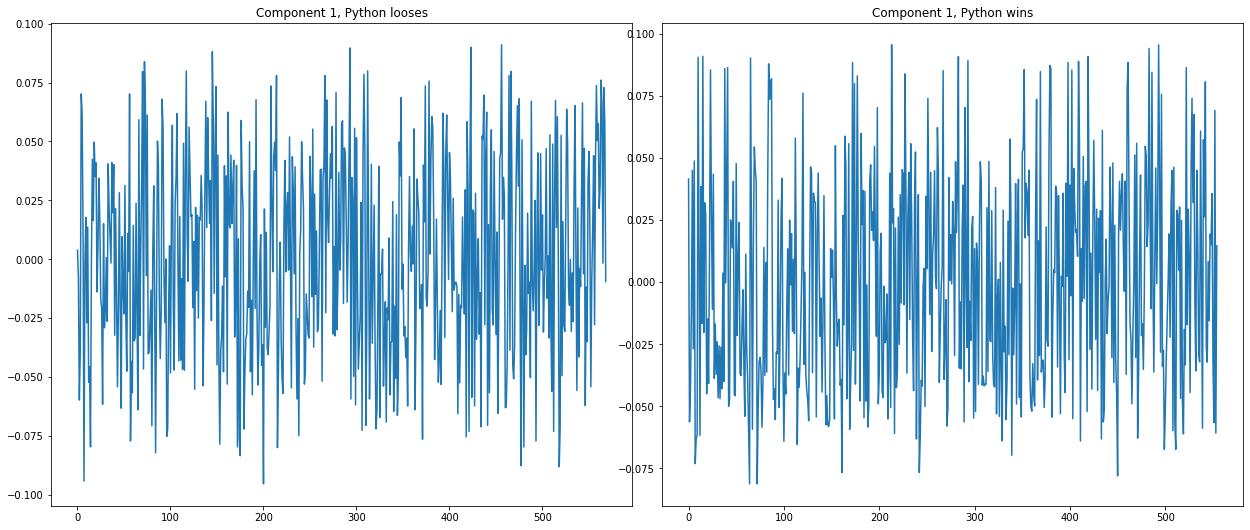

In [32]:
# Plot the components analysed by ICA in python looses and wins games in order to compare the differences.
fig = plt.figure(figsize=[18, 8])

# Plot the components' values according to the number of samples (each sample is a game). The horizontal axis indicates the number of samples.
# It means that we consider each component as a signal like the previous parts.

i = 1
j = 1
for x in X_transformed1.T:
    fig. tight_layout(pad=3.0)
    plt.subplot(X_transformed1.shape[1], 2, i)
    plt.plot(x)
    plt.title("Component " + str(j) + ", Python looses")
    i = i+2
    j = j+1
    

i = 2 
j = 1
for x in X_transformed3.T:
    fig. tight_layout(pad=3.0)
    plt.subplot(X_transformed3.shape[1], 2, i)
    plt.plot(x)
    plt.title("Component " + str(j) + ", Python wins")
    i = i+2
    j = j+1
    

We can see that with 5 independent components, we can not tell exactly the differences between python wins and looses. Moreover, it seems that although we increase the number of components, we still can not see the differences. The values are distributed like gaussian noise.

Secondly, we take into account the draw games.

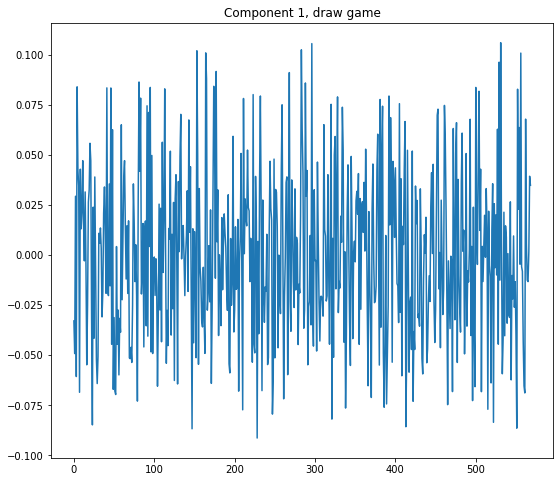

In [33]:
# Plot the data in each component for draw games
fig = plt.figure(figsize=[9, 8])
i = 1 
for x in X_transformed2.T:
    fig. tight_layout(pad=3.0)
    plt.subplot(X_transformed2.shape[1], 1, i)
    plt.plot(x)
    plt.title("Component " + str(i) + ", draw game")
    i = i+1

The draw games have fewer samples compared to others 2 types of games. As we can see, in draw games' components, there are some values that are higher than all the values in the components of wins and looses games (we can tell by looking at the axis limitation). However, due to the number of small samples of draw games and the number of total samples (5000 games), this small difference could not help us have a good classification.

Now, let's consider the components' histogram to analyse the datasets

Text(0.5, 1.0, 'Win')

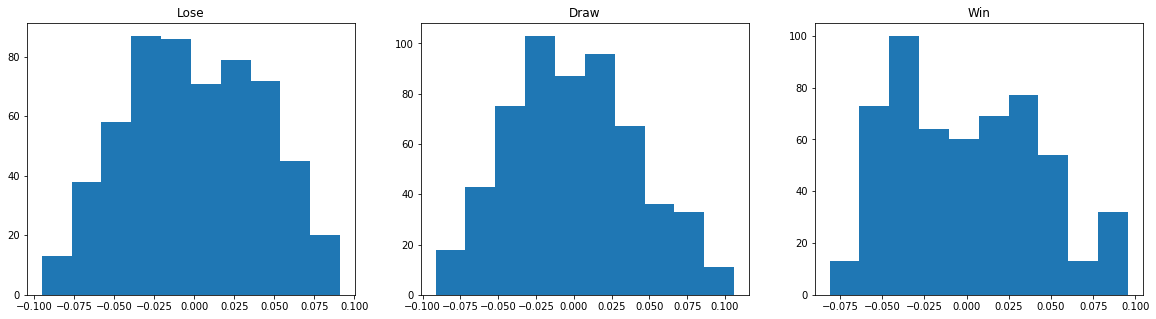

In [34]:
# Plot histogram
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(X_transformed1)
plt.title("Lose")
plt.subplot(1,3,2)
plt.hist(X_transformed2)
plt.title("Draw")
plt.subplot(1,3,3)
plt.hist(X_transformed3)
plt.title("Win")

With the histogram, we can see that the 3 kinds of games have their components to be distributed with normal distribution. The draw games have a larger variance of distribution than the other two types of games. This may be explain using cheese distribution in part a: In the win or loose games, the cheese is distributed near python or pyrat. It means the cheese (value 1) is more convergent than in draw games. 

### c) ICA with SVM

In this part, we will observe the performance of SVM using ICA with signal approach.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [35]:
# We evaluate the performance of the number of components on classification results.
for i in [1,5,10,15,20,22]:
    transformer_all = FastICA(n_components=i,algorithm='deflation',
                              random_state=0)
    x_py_c, x_py_meanX = center(x_py)
    X_transformed = transformer_all.fit_transform (x_py_c)
    x_train, x_test, y_train, y_test = train_test_split(X_transformed, y_py, test_size = 0.2, random_state=0)
    clf = SVC(kernel = 'rbf',C = 1.5)
    clf.fit(x_train,y_train)
    print ('The number of components is: ' + str(i))
    print('Accuracy of our SVM model on the training data is {:.2f} out of 1'.format(clf.score(x_train, y_train)))
    print('Accuracy of our SVM model on the test data is {:.2f} out of 1'.format(clf.score(x_test, y_test)))

The number of components is: 1
Accuracy of our SVM model on the training data is 0.46 out of 1
Accuracy of our SVM model on the test data is 0.50 out of 1
The number of components is: 5
Accuracy of our SVM model on the training data is 0.69 out of 1
Accuracy of our SVM model on the test data is 0.63 out of 1
The number of components is: 10
Accuracy of our SVM model on the training data is 0.83 out of 1
Accuracy of our SVM model on the test data is 0.74 out of 1
The number of components is: 15
Accuracy of our SVM model on the training data is 0.91 out of 1
Accuracy of our SVM model on the test data is 0.79 out of 1
The number of components is: 20
Accuracy of our SVM model on the training data is 0.94 out of 1
Accuracy of our SVM model on the test data is 0.82 out of 1
The number of components is: 22
Accuracy of our SVM model on the training data is 0.94 out of 1
Accuracy of our SVM model on the test data is 0.83 out of 1


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_py, y_py, test_size = 0.2, random_state=0)
clf = SVC(kernel = 'rbf',C = 1.5)
clf.fit(x_train,y_train)
#print ('The number of components is: ' + str(i))
print('Accuracy of our SVM model on the training data is {:.2f} out of 1'.format(clf.score(x_train, y_train)))
print('Accuracy of our SVM model on the test data is {:.2f} out of 1'.format(clf.score(x_test, y_test)))

Accuracy of our SVM model on the training data is 0.94 out of 1
Accuracy of our SVM model on the test data is 0.83 out of 1


It is obvious that if we increase the number of components, the training accuracy will increase. However, the accuracy in testing dataset does not always increase. In fact, increasing the number of components will give the model more information to calculate, thus the training accuracy gets better. However, using many components also gives high chance to get overfitting. We can see in the example above that when the number of components increase, the gap between training and testing accuracy also becomes larger. It can be explained that some components contain the information which leads to overfitting problem. For example, from 10 components to 15 components, the testing accuracy decreases by 1%. This may be caused by the additional components which contain overfitting information.

## 5. Conclusion

Independent Component Analysis (ICA) is usually used for decomposing data into many sub-components so that we can analyse its characteristics. In Pyrat dataset, separating the components using ICA will help us reduce the training time for the model. However, using ICA could not show clearly the differences between Python wins and looses games. Moreover, when using ICA in SVM, increasing the number of components may lead to overfitting problem. 

## 6. Reference

1. Cory Maklin, Independent Component Analysis (ICA) In Python, Available at: https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

2. Aapo Hyvarinen, The FastICA Algorithm, Available at:http://cis.legacy.ics.tkk.fi/aapo/papers/IJCNN99_tutorialweb/node28.html
